In [1]:
import numpy as np
import h5py
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import gridspec
from matplotlib.colors import colorConverter
plt.rc('text', usetex=True)

import seaborn as sns

import glob
import os
import pickle
import sys

from astropy.table import Table


In [2]:
from colossus.halo import mass_adv
from colossus.cosmology import cosmology
cosmology.setCosmology('planck18')

In [3]:
def open_pkl(file_name):
    pkl = open(file_name,'rb')
    array = pickle.load(pkl)#, encoding='latin')
    pkl.close()  
    return array

In [84]:
def get_median(bins, x, y):
    
    x_y =np.vstack([x,y])
    
    bins_y=[]
    bins_x=[]
    
    err_y=[]
    err_x=[]
    
    for i in range(len(bins)-1):
        l=bins[i]
        u=bins[i+1]
        
        mask = [(x_y[0]>l) & (x_y[0]<u)]

        y_in_range = x_y[1][mask]
        x_in_range = x_y[0][mask]
        
        print('{0} galaxies in this bin'.format(len(y_in_range)))
        
#         print(len(y_in_range))
        
        bins_y.append(np.median(y_in_range))
        bins_x.append(np.median(x_in_range))
        
#         err_y.append(np.std(y_in_range)/np.sqrt(len(y_in_range)))
#         err_x.append(np.std(x_in_range)/np.sqrt(len(x_in_range)))
        
    #error on the mean
        err_y.append(np.std(10**y_in_range)/np.sqrt(len(y_in_range)))
        err_x.append(np.std(10**x_in_range)/np.sqrt(len(x_in_range)))
        
        
    bins_y, bins_x, err_y, err_x =  np.array(bins_y), np.array(bins_x), np.array(err_y), np.array(err_x)
    

    
        
    return bins_x, bins_y, err_x, err_y
               
    
def errors_for_plots(bins_x, bins_y, err_x, err_y):
       
    upper_err_y= np.log10(10**bins_y + err_y) - bins_y
    lower_err_y= bins_y - np.log10(10**bins_y - err_y)
    upper_err_x= np.log10(10**bins_x + err_x) - bins_x
    lower_err_x= bins_x - np.log10(10**bins_x - err_x)
    
    return [lower_err_x,upper_err_x], [lower_err_y,upper_err_y]

In [59]:
def make_Mstar_Mhalo_plot(HSC_data, mass_radius, Illustris_data=None, TNG_data=None, output_filename=None):
    
    mass_bins = np.linspace(13.0,14.25,4)
    
    fig = plt.figure(figsize=[10,10])

    #hsc
    hsc_mvir = np.array(HSC_data['m_vir'])
    
    if mass_radius == 'outer':
        hsc_mstar = np.array(np.log10(10**HSC_data['m_100']-10**HSC_data['m_30']))
        hsc_mvir = hsc_mvir[~np.isinf(hsc_mstar)]
        hsc_mstar = hsc_mstar[~np.isinf(hsc_mstar)]
        
    else:
        hsc_mstar = np.array(HSC_data['m_{0}'.format(mass_radius)])

    sns.kdeplot(hsc_mvir, hsc_mstar, cmap="Greys", shade=True, shade_lowest=False, legend=False,  n_levels=7,
                zorder =1, colors=None)
    contours_ax = sns.kdeplot(hsc_mvir, hsc_mstar, colors='grey', cmap=None, shade_lowest=False,
                              n_levels=7, linewidths=1)
    
    #only show scatter points outside the contours: https://stackoverflow.com/questions/19311957/plot-contours-for-the-densest-region-of-a-scatter-plot
    inside = np.full_like(hsc_mvir,False,dtype=bool)
    for level in contours_ax.collections[1].get_paths():
        inside |= level.contains_points(zip(*(hsc_mvir, hsc_mstar)))
    plt.scatter(hsc_mvir[~inside], hsc_mstar[~inside], marker='o', color='k',
                s=1, linewidth=0, alpha=0.5, zorder=0)
    ############

    bins_x_hsc, bins_y_hsc, err_x_hsc, err_y_hsc = get_median(mass_bins,hsc_mvir, hsc_mstar)
#     plt.plot(bins_x_hsc, bins_y_hsc, markersize=20, color=colorConverter.to_rgba('k', alpha=.4),
#              linewidth=5, marker='s', zorder=5, markeredgecolor=colorConverter.to_rgba('k', alpha=1), 
#              markeredgewidth=3, label='HSC') #medians

    plot_err_x_hsc, plot_err_y_hsc = errors_for_plots(bins_x_hsc, bins_y_hsc, err_x_hsc, err_y_hsc)
    plt.errorbar(bins_x_hsc, bins_y_hsc, plot_err_x_hsc, plot_err_y_hsc, markersize=25,
                 color=colorConverter.to_rgba('k', alpha=0.5),
                 linewidth=5, marker='.', zorder=6, markerfacecolor =colorConverter.to_rgba('k', alpha=1),
                     markeredgecolor =colorConverter.to_rgba('k', alpha=1), 
                     ecolor=colorConverter.to_rgba('k', alpha=1), label='HSC')
    
    if Illustris_data:
        illustris_mvir = np.array(Illustris_data['m_vir'])
        if mass_radius == 'outer':
            illustris_mstar = np.array(np.log10(10**Illustris_data['m_1d_100']-10**Illustris_data['m_1d_30']))
        else:
            illustris_mstar = np.array(Illustris_data['m_1d_{0}'.format(mass_radius)])
        plt.scatter(illustris_mvir, illustris_mstar, color=u'#d62728', s=30, linewidth=0, alpha=0.5,
                    zorder=5)
        bins_x_illustris, bins_y_illustris, err_x_illustris, err_y_illustris = get_median(mass_bins,
                                                                                          illustris_mvir,
                                                                                          illustris_mstar)
#         plt.plot(bins_x_illustris, bins_y_illustris, markersize=20,
#                  color=colorConverter.to_rgba(u'#d62728', alpha=.5), linewidth=5, marker='s', zorder=6,
#                  markeredgecolor=colorConverter.to_rgba(u'#d62728', alpha=1), markeredgewidth=3,
#                  label='Illustris')#medians
        plot_err_x_illustris, plot_err_y_illustris = errors_for_plots(bins_x_illustris, bins_y_illustris, err_x_illustris, err_y_illustris)
        plt.errorbar(bins_x_illustris, bins_y_illustris, plot_err_x_illustris, plot_err_y_illustris,
                     markersize=25,
                 color=colorConverter.to_rgba(u'#d62728', alpha=0.75),
                 linewidth=5, marker='.', zorder=6, markerfacecolor =colorConverter.to_rgba(u'#d62728', alpha=1),
                     markeredgecolor =colorConverter.to_rgba(u'#d62728', alpha=1), 
                     ecolor=colorConverter.to_rgba(u'#d62728', alpha=1),
                 label='Illustris')#medians
        
    if TNG_data:
        tng_mvir = np.array(TNG_data['m_vir'])
        if mass_radius == 'outer':
            tng_mstar = np.array(np.log10(10**TNG_data['m_1d_100']-10**TNG_data['m_1d_30']))
        else:
            tng_mstar = np.array(TNG_data['m_1d_{0}'.format(mass_radius)])
        plt.scatter(tng_mvir, tng_mstar, color=u'#1f77b4', s=30, linewidth=0, zorder=5, alpha=0.5)
        
        bins_x_tng, bins_y_tng, err_x_tng, err_y_tng = get_median(mass_bins, tng_mvir, tng_mstar)
#         plt.plot(bins_x_tng, bins_y_tng, markersize=20, color=colorConverter.to_rgba(u'#1f77b4', alpha=.5),
#                  linewidth=5, marker='s', zorder=6, markeredgecolor=colorConverter.to_rgba('b', alpha=1),
#                 label='TNG', markeredgewidth=3)#medians
        
        plot_err_x_tng, plot_err_y_tng = errors_for_plots(bins_x_tng, bins_y_tng, err_x_tng, err_y_tng)
        plt.errorbar(bins_x_tng, bins_y_tng, plot_err_x_tng, plot_err_y_tng, markersize=25,
                     color=colorConverter.to_rgba(u'#1f77b4', alpha=0.75),
                 linewidth=5, marker='.', zorder=8, markerfacecolor =colorConverter.to_rgba(u'#1f77b4', alpha=1),
                     markeredgecolor =colorConverter.to_rgba(u'#1f77b4', alpha=1), 
                     ecolor=colorConverter.to_rgba(u'#1f77b4', alpha=1),
                label='TNG')#medians

    #PONOS
    if mass_radius == 'outer':
        ponos_v_mass = np.log10(10**ponos_v_masses['m_100'] - 10**ponos_v_masses['m_30'])
        ponos_sb_mass = np.log10(10**ponos_sb_masses['m_100'] - 10**ponos_sb_masses['m_30'])
    else:
        ponos_v_mass = ponos_v_masses['m_{0}'.format(mass_radius)]
        ponos_sb_mass = ponos_sb_masses['m_{0}'.format(mass_radius)]
        
    plt.scatter(ponos_m_vir, ponos_v_mass, c='#2ca02c', label='PonosV', marker='^', s=200, zorder=10)
    plt.scatter(ponos_m_vir, ponos_sb_mass, c='#ff7f0e', label='PonosSB', marker='^', s=200, zorder=10)
    
    #make cut to include M_100>11.5
    plt.axvline(13.0, c='grey', linewidth=1, linestyle='--')
    if mass_radius == 100:
        plt.axhline(11.2, c='grey', linewidth=1, linestyle='--')

    plt.xlabel('$\log (M_{\mathrm{vir}})$', fontsize=40)
    if mass_radius == 'outer':
        plt.ylabel(r'$\log (M_{{\star,  100  \mathrm{{kpc}}}} - M_{{\star,  30  \mathrm{{kpc}}}})$', fontsize=40)
    else:
        plt.ylabel(r'$\log (M_{{\star,  {0}  \mathrm{{kpc}}}})$'.format(str(mass_radius)), fontsize=40)

    plt.tick_params(axis='both', which='major', labelsize=30)

    plt.xlim([12,14.25])
    if mass_radius ==10:
        plt.ylim([10.7,12.1])
    elif mass_radius == 'outer':
        plt.ylim([9,12.2])
    else:
            plt.ylim([11,12.2])

    #legend
    lgnd = plt.legend(fontsize=30, scatterpoints=1, frameon=False)#, markerscale=2.)#, handler_map={hsc_points: HandlerLine2D(numpoints=3)})
    #change the marker size manually for both lines
#     lgnd.legendHandles[0]._sizes = [20.]

    if output_filename:
        fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/{0}'.format(output_filename),
                dpi=100, format='pdf', bbox_inches='tight')
    else:
        fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/Mhalo_vs_M{0}.pdf'.format(str(mass_radius)),
                    dpi=100, format='pdf', bbox_inches='tight')



    plt.show()
    
    return

# files

## simulations

In [6]:
illustris_masses_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/Illustris_masses_highres.pkl'
tng_masses_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/TNG_masses_highres.pkl'
illustris_masses = open_pkl(illustris_masses_file)
tng_masses = open_pkl(tng_masses_file)



In [7]:
#ponos
ponos_v_masses = {'m_10':11.74676299771465,  'm_30':11.835997387319807, 'm_100':11.88221989150391}
ponos_sb_masses = {'m_10':11.94239742523574, 'm_30':12.009701166202616, 'm_100':12.033305728795845}
ponos_m_vir = 13.02

### HSC

In [8]:
hsc_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/HSC/s16a_mass_good_mhalo_frac4_180503.fits'
hsc_table = Table.read(hsc_file)

In [9]:
hsc_m_vir_sr = hsc_table['logmh_vir_symbol']
hsc_m_vir_rf = hsc_table['logmh_vir_forest']

hsc_m100 = hsc_table['logm_100']
hsc_m30 = hsc_table['logm_30']
hsc_m10 = hsc_table['logm_10']

In [10]:
# HSC_data = {'m_vir':hsc_m_vir_sr[:100], 'm_100':hsc_m100[:10000], 'm_30':hsc_m30[:10000], 'm_10':hsc_m10[:10000]}
HSC_data = {'m_vir':hsc_m_vir_sr[:], 'm_100':hsc_m100[:], 'm_30':hsc_m30[:], 'm_10':hsc_m10[:]}

# PLOTS 

/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


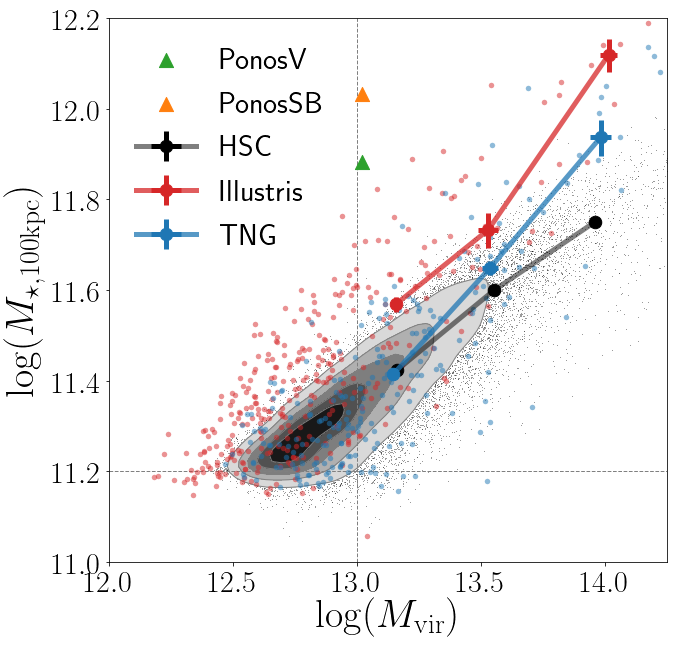

In [40]:
make_Mstar_Mhalo_plot(HSC_data,  100, Illustris_data = illustris_masses,
                     TNG_data = tng_masses)
                      

/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


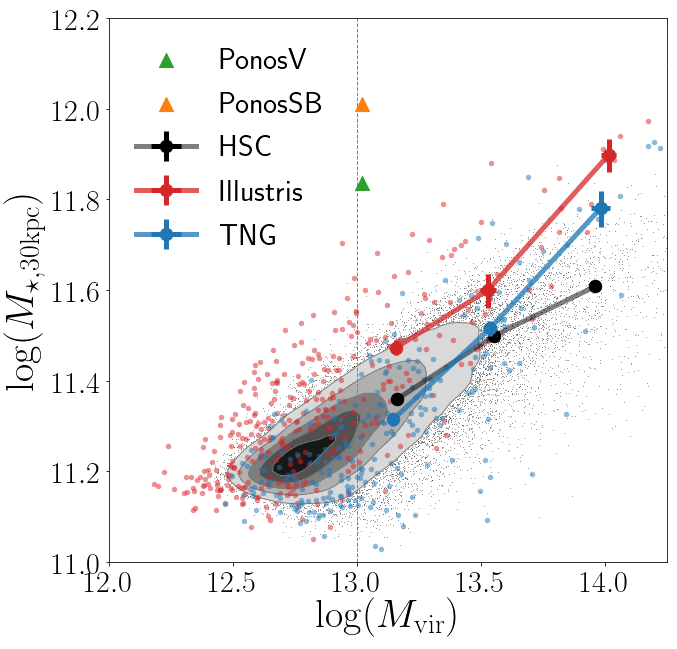

In [41]:
make_Mstar_Mhalo_plot(HSC_data, 30, Illustris_data = illustris_masses,
                     TNG_data = tng_masses)

/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


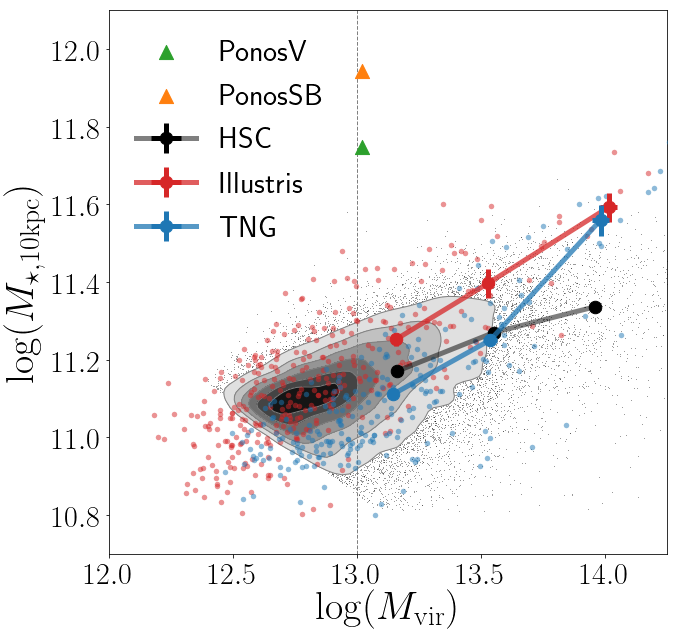

In [42]:
make_Mstar_Mhalo_plot(HSC_data,  10, Illustris_data = illustris_masses,
                     TNG_data = tng_masses)

/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


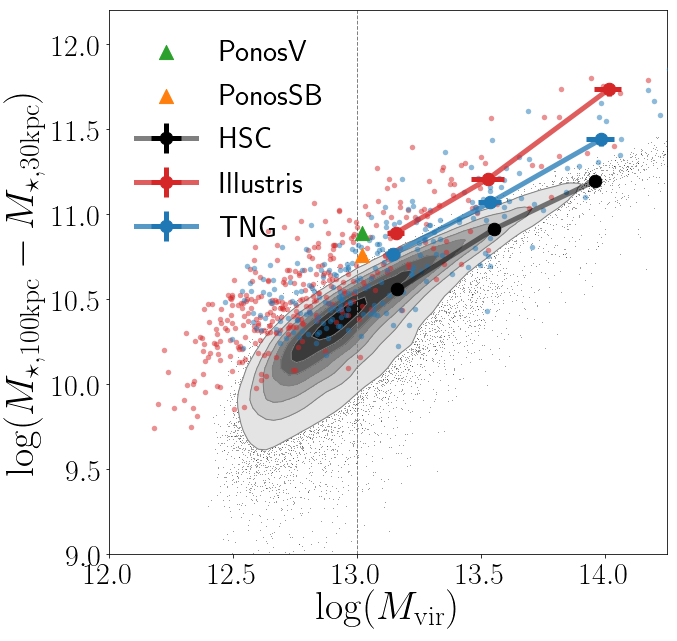

In [43]:
make_Mstar_Mhalo_plot(HSC_data,  'outer', Illustris_data = illustris_masses,
                     TNG_data = tng_masses)

## Quantifying differences

In [80]:
def quantify_differences(mass_radius, mass_bins, hsc_data, sim_data, sim_name):

    print(sim_name)
    print('mass radius: {0}'.format(mass_radius))
    print('MASS BINS: {0}'.format(mass_bins))

    hsc_mvir = np.array(HSC_data['m_vir'])
    #hsc
    if mass_radius == 'outer':
        hsc_mstar = np.array(np.log10(10**HSC_data['m_100']-10**HSC_data['m_30']))
        hsc_mvir = hsc_mvir[~np.isinf(hsc_mstar)]
        hsc_mstar = hsc_mstar[~np.isinf(hsc_mstar)]
        
        sim_mstar = np.array(np.log10(10**sim_data['m_1d_100']-10**sim_data['m_1d_30']))
  
    else:
        hsc_mstar = np.array(HSC_data['m_{0}'.format(mass_radius)])
        
        sim_mstar = np.array(sim_data['m_1d_{0}'.format(mass_radius)])

    bins_x_hsc, bins_y_hsc, err_x_hsc, err_y_hsc = get_median(mass_bins, hsc_mvir, hsc_mstar)

    sim_mvir = np.array(sim_data['m_vir'])
    bins_x_sim, bins_y_sim, err_x_sim, err_y_sim = get_median(mass_bins, sim_mvir, sim_mstar)


    print('ABSOLUTE DIFFERENCES')
    print(np.log10(np.abs(10**np.array(bins_y_sim) - 10**np.array(bins_y_hsc))))

    print('FRACTIONAL DIFFERENCES')
    print(np.abs(10**np.array(bins_y_sim) - 10**np.array(bins_y_hsc))/10**np.array(bins_y_hsc))

    print('NORMALIZED BY SIM ERROR')
    print(np.abs(10**np.array(bins_y_sim) - 10**np.array(bins_y_hsc))/ err_y_sim)
    
    print('###########################')

In [85]:
mass_bins = np.linspace(13.0,14.25,4)

for radius in [10,30,100, 'outer']:
    for sim, sim_data in zip(['TNG', 'ILLUSTRIS'], [tng_masses, illustris_masses]):
        quantify_differences(radius,mass_bins, HSC_data, sim_data, sim)

TNG
mass radius: 10
MASS BINS: [13.         13.41666667 13.83333333 14.25      ]
9146 galaxies in this bin
2807 galaxies in this bin
638 galaxies in this bin
82 galaxies in this bin
35 galaxies in this bin
13 galaxies in this bin
ABSOLUTE DIFFERENCES
[10.27782027  9.91089603 11.16488021]
FRACTIONAL DIFFERENCES
[0.12796163 0.04374937 0.67382668]
NORMALIZED BY SIM ERROR
[5.08265197 0.71970219 4.8578348 ]
###########################
ILLUSTRIS
mass radius: 10
MASS BINS: [13.         13.41666667 13.83333333 14.25      ]
9146 galaxies in this bin
2807 galaxies in this bin
638 galaxies in this bin
62 galaxies in this bin
23 galaxies in this bin
6 galaxies in this bin
ABSOLUTE DIFFERENCES
[10.48569958 10.80153694 11.24265069]
FRACTIONAL DIFFERENCES
[0.20651855 0.34010475 0.80596965]
NORMALIZED BY SIM ERROR
[3.78362036 4.32741565 5.50984262]
###########################
TNG
mass radius: 30
MASS BINS: [13.         13.41666667 13.83333333 14.25      ]
9146 galaxies in this bin
2807 galaxies in thi

/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10


##  over the entire sample

In [86]:
mass_bins = np.linspace(13.0,14.25,2)

for radius in [10,30,100, 'outer']:
    for sim, sim_data in zip(['TNG', 'ILLUSTRIS'], [tng_masses, illustris_masses]):
        quantify_differences(radius,mass_bins, HSC_data, sim_data, sim)

TNG
mass radius: 10
MASS BINS: [13.   14.25]
12591 galaxies in this bin
130 galaxies in this bin
ABSOLUTE DIFFERENCES
[10.16829659]
FRACTIONAL DIFFERENCES
[0.09389432]
NORMALIZED BY SIM ERROR
[2.00463871]
###########################
ILLUSTRIS
mass radius: 10
MASS BINS: [13.   14.25]
12591 galaxies in this bin
91 galaxies in this bin
ABSOLUTE DIFFERENCES
[10.59638843]
FRACTIONAL DIFFERENCES
[0.2516119]
NORMALIZED BY SIM ERROR
[4.17349331]
###########################
TNG
mass radius: 30
MASS BINS: [13.   14.25]
12591 galaxies in this bin
130 galaxies in this bin
ABSOLUTE DIFFERENCES
[9.99556077]
FRACTIONAL DIFFERENCES
[0.0402446]
NORMALIZED BY SIM ERROR
[0.7319613]
###########################
ILLUSTRIS
mass radius: 30
MASS BINS: [13.   14.25]
12591 galaxies in this bin
91 galaxies in this bin
ABSOLUTE DIFFERENCES
[10.83223058]
FRACTIONAL DIFFERENCES
[0.27629781]
NORMALIZED BY SIM ERROR
[3.84099741]
###########################
TNG
mass radius: 100
MASS BINS: [13.   14.25]
12591 galaxies i

/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10
